In [1]:
import numpy as np 
import os
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import math
from matplotlib import pyplot as plt

import sys
sys.path.append('../utils')

from text.utils import save_text_state, load_text_state, build_text_state, load_books, Vocabulary
from model.utils import get_device, load_model_state, save_model_state, build_model_state

from multitext_model import MultiTextModel, get_loss_function
import torchtext

### Verify if CUDA is available

In [2]:
device = get_device()
print(device)

cuda


### Loading word vectors and training/validation dataset

In [3]:
LOAD_CHECKPOINTS = True

CHECKPOINT_BASE = 'checkpoints'
DATASET_FILENAME = '../datasets/books.pk'
AUTHORS = ['Friedrich Nietzsche', 'Ernest Hemingway', 'Oscar Wilde']

VAL_PARTITION = 0.3 
MIN_SENTENCE_LENGTH = 5
MAX_SENTENCE_LENGTH = 22
BATCH_SIZE = 8

VECTORS_LOADED = 40000

In [4]:
vocabs = []
train_datasets = []
test_datasets = []

min_len_train = None
min_len_test = None

for author in AUTHORS:
    # Try loading dataset, if it doesn't exists then creates it
    try:
        if not LOAD_CHECKPOINTS:
            print('New training required')
            raise Error('New training required')

        vocab, train_dataset, test_dataset = load_text_state(os.path.join(CHECKPOINT_BASE, author + '_text.pk'))    
        print('Checkpoint loaded')
    except:        
        books = load_books(DATASET_FILENAME, author=author)
        vocab, train_dataset, test_dataset = build_text_state(books, MIN_SENTENCE_LENGTH, MAX_SENTENCE_LENGTH, VAL_PARTITION, vocab_name=author)  
        print('No checkpoint found. New partition.')
        print('Included books:')
        for book in books:
            print('\t', book)
            
    
    train_datasets.append(train_dataset)
    test_datasets.append(test_dataset)
    vocabs.append(vocab)

Checkpoint loaded
Checkpoint loaded
Checkpoint loaded


In [5]:
for idx, author in enumerate(AUTHORS):
    save_text_state(
        os.path.join(CHECKPOINT_BASE, author + '_text.pk'), 
        vocabs[idx], 
        train_datasets[idx], 
        test_datasets[idx]
    ) 

In [6]:
# Build full vocab
vocab = Vocabulary('Multitext')
fasttext = torchtext.vocab.FastText(language='en', max_vectors=VECTORS_LOADED - len(vocab), cache='../.vector_cache')

for word in fasttext.stoi.keys():
    vocab.add_word(word)        

In [7]:
# Map all datasets to new indices
train_dataloaders = []
test_dataloaders = []

for train_dataset, test_dataset in zip(train_datasets, test_datasets):
    train_dataset.change_vocab(vocab)
    test_dataset.change_vocab(vocab)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    train_dataloaders.append(train_dataloader)
    
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_dataloaders.append(test_dataloader)
    
    print(len(train_dataloader), len(test_dataloader))

1555 667
1861 798
1150 493


### Loading components

In [8]:
VOCAB_SIZE = len(vocab)

LEARNING_RATE = 1e-4
BETA_1 = 0.9
BETA_2 = 0.999
EPOCHS = 50
NUM_HEADS = 15
ENCODER_LAYERS = 2
DECODER_LAYERS = 1
EMBEDDING_SIZE = 512
FF_DIM = 1024
DROPOUT=0.2
STEP_LR_DECAY = 15
LR_FACTOR_DECAY = 0.7

In [9]:
print(type(fasttext.vectors))

<class 'torch.Tensor'>


In [10]:
model = MultiTextModel(
    authors = AUTHORS,
    vocab_size=VOCAB_SIZE,
    embedding_size=fasttext.dim, 
    #embedding_size=EMBEDDING_SIZE, 
    num_heads=NUM_HEADS, 
    encoder_layers=ENCODER_LAYERS, 
    decoder_layers=DECODER_LAYERS, 
    dim_feedforward=FF_DIM,
    dropout=DROPOUT
)


if fasttext.vectors.size()[0] < VECTORS_LOADED:
    vectors = torch.normal(0, 0.1, size=(VECTORS_LOADED - fasttext.vectors.size()[0], fasttext.dim))
    vectors = torch.cat([vectors, fasttext.vectors], dim=0)
else:
    vectors = fasttext.vectors

model.embedding.weight.data.copy_(vectors)


optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=LEARNING_RATE,
    betas=(BETA_1, BETA_2)
)
    
loss_fn = get_loss_function(len(AUTHORS))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_LR_DECAY, gamma=LR_FACTOR_DECAY)

In [11]:
try:
    if not LOAD_CHECKPOINTS:
        print('New training required')
        raise Error('New training required')
        
    model, optimizer, last_epoch, train_loss_history, val_loss_history, best_val_loss = load_model_state(
        os.path.join(CHECKPOINT_BASE, 'best.pt'), 
        model, 
        optimizer
    )
    
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)

    print('Checkpoint loaded')
    
except:
    last_epoch, train_loss_history, val_loss_history, best_val_loss = build_model_state()
    print('No checkpoints found. New training.')
    pass

model = model.to(device)


No checkpoints found. New training.


### Training and validation

In [12]:
def train_step(transformer, loss_fn, optimizer, source, target):
    transformer.train()

    transformer.zero_grad()
    optimizer.zero_grad()

    decodings = transformer(source, target)
    
    loss = loss_fn(source, decodings)
    loss.backward()      
    optimizer.step()
    return loss.item()    

In [13]:
def val_step(transformer, loss_fn, source, target):
    transformer.eval()
    
    with torch.no_grad():
        decodings = transformer(source, target)
        loss = loss_fn(source, decodings)

        return loss.item(), decodings

In [14]:
def sample(iterators, dataloaders, device):
    source = []
    target = []
    for idx, it in enumerate(iterators):
        try:
            example = next(it).to(device)
        except:
            iterators[idx] = iter(dataloaders[idx])
            example = next(iterators[idx]).to(device)

        source.append(example[:, 1:])
        target.append(example[:, :-1])
    return source, target

In [15]:
# Define steps where examples will be sampled 
test_dls_its = [ iter(test_dataloaders[idx]) for idx, _ in enumerate(AUTHORS) ]

# For EPOCHS
for epoch in range(last_epoch + 1, EPOCHS + last_epoch):
    
    print('*************************** EPOCH {} ***************************'.format(epoch))

    # Restart train datasets
    train_dls_its = [ iter(train_dataloaders[idx]) for idx, _ in enumerate(AUTHORS) ]
    # Get max of dataloaders lengths
    total_batches = max([ len(train_dataloaders[idx]) for idx, _ in enumerate(AUTHORS)  ])
    # Progress bar for training dataset
    progress_bar = tqdm(range(total_batches))
    
    train_loss = 0

    # For all data in training dataset
    # Training
    for batch_idx in progress_bar:
        
        # Add train loss to progress bar
        progress_bar.set_postfix({
            'tr_loss': train_loss / (batch_idx + 1), 
            'lr': scheduler.get_lr()[0]
        })

        # Train step
        source, target = sample(train_dls_its, train_dataloaders, device)
        train_loss += train_step(model, loss_fn, optimizer, source, target)


        if batch_idx == 0:
            source, target = sample(test_dls_its, test_dataloaders, device)
            
            for idx, author in enumerate(AUTHORS):
                
                src = [source[idx]] * len(AUTHORS)
                tgt = [target[idx]] * len(AUTHORS)
                                
                with torch.no_grad():
                    _, decodings = val_step(model, loss_fn, src, tgt)
                
                # Print real sentence
                real = vocab.to_words(src[idx][0].cpu().numpy())
                print('-------------------- Author {} --------------------'.format(author))
                print('Real: {}'.format(' '.join(real)))
                
                
                # Decode and print recovered sentences
                for jdx, jauthor in enumerate(AUTHORS):
                    decoded_sent = torch.argmax(decodings[jdx][0], dim=-1).cpu().numpy()
                    
                    print('***************************************************')
                    print('Decoded {}: {}'.format(jauthor, ' '.join(vocab.to_words(decoded_sent))))

    # Validation
    val_dls_its = [ iter(test_dataloaders[idx]) for idx, _ in enumerate(AUTHORS) ]
    total_batches = max([ len(test_dataloaders[idx]) for idx, _ in enumerate(AUTHORS)  ])
    
    # Progress bar for training dataset
    progress_bar = tqdm(range(total_batches))
    val_loss = 0

    for batch_idx in progress_bar:
        progress_bar.set_postfix({
            'val_loss': val_loss / (batch_idx + 1)
        })
                
        source, target = sample(test_dls_its, test_dataloaders, device)
        with torch.no_grad():
            val_loss += val_step(model, loss_fn, source, target)[0]
    
    # Save losses in history
    train_loss_history.append(train_loss / len(train_dataloader))
    val_loss_history.append(val_loss / len(test_dataloader))
    
    # If this model is best than other
    if best_val_loss is None or val_loss / len(test_dataloader) < best_val_loss:
        best_val_loss = val_loss / len(test_dataloader)
        
        save_model_state(
            os.path.join(CHECKPOINT_BASE, 'best.pt'), 
            model, 
            optimizer, 
            epoch, 
            train_loss_history, 
            val_loss_history, 
            best_val_loss
        )
        
    # Save last model
    save_model_state(
        os.path.join(CHECKPOINT_BASE, 'last.pt'), 
        model, 
        optimizer, 
        epoch, 
        train_loss_history, 
        val_loss_history, 
        best_val_loss
    )    
    
    scheduler.step()    

*************************** EPOCH 1 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: on the other hand , this desire , thus it ought to be , has only called forth that other desire , <eos>
***************************************************
Decoded Friedrich Nietzsche: flesh shutouts flesh wenceslaus flesh shutouts shutouts shutouts shutouts lps wenceslaus shutouts colonel lps shutouts wenceslaus flesh cathedrals cathedrals flesh wenceslaus shutouts shutouts
***************************************************
Decoded Ernest Hemingway: ta walcott ta ta ta ta ta walcott ta ta ta ta ta walcott ta ta ta walcott walcott walcott ta walcott ta
***************************************************
Decoded Oscar Wilde: shanxi shanxi shanxi shanxi shanxi shanxi shanxi shanxi shanxi shanxi shanxi shanxi shanxi shanxi shanxi shanxi shanxi shanxi shanxi shanxi shanxi shanxi shanxi
-------------------- Author Ernest Hemingway --------------------
Real: the other day , madame <unk> said , there was a little fren


*************************** EPOCH 2 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: this vulgar taste which <unk> greater importance to intoxication than nutrition did not by any means originate in the lower ranks of <eos>
***************************************************
Decoded Friedrich Nietzsche: this god life which <unk> by life to life more life do not by be can world in the by , of <eos>
***************************************************
Decoded Ernest Hemingway: this pop pop his <unk> colonel man to colonel said two like not on there can old in the old , of <eos>
***************************************************
Decoded Oscar Wilde: this cried art which <unk> by life to use than rose me not by be can great in the by , of <eos>
-------------------- Author Ernest Hemingway --------------------
Real: she put her <unk> hand up to her lips <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Fried


*************************** EPOCH 3 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: <unk> do they exert themselves , like an <unk> which <unk> to stand upon its head <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: <unk> do they often themselves , like an <unk> which <unk> to better upon its after <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: <unk> do they turned make , like an <unk> which <unk> to put their the head <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: <unk> do they extremely them , like an <unk> which <unk> to give upon its head <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: he ' s going to be rich as hell some day <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
*******************


*************************** EPOCH 4 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: but even these have their weary hours when a series of venerable words and sounds and a mechanical , pious <unk> does <eos>
***************************************************
Decoded Friedrich Nietzsche: but even these have their weary take when a powerful of origin words and heard and a vision , belief <unk> does <eos>
***************************************************
Decoded Ernest Hemingway: but even these have their her take when a ring of george suppose and heard and a bulls , thought <unk> does <eos>
***************************************************
Decoded Oscar Wilde: but even these have their critic days when a rich of england words and heard and a surroundings , soul <unk> does <eos>
-------------------- Author Ernest Hemingway --------------------
Real: they had gone a little too far to the left and <unk> waved to <unk> them toward us <pad> <pad> <pad> <pad> <eos>
********************************


*************************** EPOCH 5 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: the ass , however , here <unk> ye a <unk> <unk> he through the world <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: the ass , however , here <unk> ye a <unk> <unk> he through the world <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: the ain , because , here <unk> brett a <unk> <unk> he through the world <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: the ghost , however , here <unk> dance a <unk> <unk> he through the world <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: you ' d have a hell of a time explaining that to these sport writers though , hogan said <pad> <pad> <pad> <eos>
********************************


*************************** EPOCH 6 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: we , however , want to be the poets of our life , and first of all in the smallest and most <eos>
***************************************************
Decoded Friedrich Nietzsche: we , however , want to be the poets of our life , and first of all in the smallest and most <eos>
***************************************************
Decoded Ernest Hemingway: we , however , want to be the portrait of our life , and first of all in the smallest and most <eos>
***************************************************
Decoded Oscar Wilde: we , however , want to be the poets of our life , and first of all in the modern and most <eos>
-------------------- Author Ernest Hemingway --------------------
Real: edna was the girl ' s name <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: he was the woman ' s nam


*************************** EPOCH 7 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: each one of us bears a creative solitude within himself and his consciousness of it forms an exotic <unk> of <unk> round <eos>
***************************************************
Decoded Friedrich Nietzsche: each one of us bears a creative solitude within himself and his consciousness of it forms an imitating <unk> of <unk> round <eos>
***************************************************
Decoded Ernest Hemingway: each one of us showing a wild eye these himself and his blood of it or an shape <unk> of <unk> car <eos>
***************************************************
Decoded Oscar Wilde: each one of us line a creative dream within himself and his consciousness of it forms an popular <unk> of <unk> round <eos>
-------------------- Author Ernest Hemingway --------------------
Real: who ' d want to ? i say , jake , do we get a drink ? you get it while i <eos>
***************************************************
Decod


*************************** EPOCH 8 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: poetry must precede the plastic art <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: poetry must superfluous the plastic art <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: walcott must notice the curve art <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: poetry must incomplete the ball art <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: he was not going to die <pad> <pad> <pad> <pad> <pad> <pad> <pad> <


*************************** EPOCH 9 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: wagner has not the power to <unk> and liberate the soul of those he <unk> <unk> wagner is not sure of himself <eos>
***************************************************
Decoded Friedrich Nietzsche: wagner has not the power to <unk> and share the soul of those he <unk> <unk> wagner is not sure of himself <eos>
***************************************************
Decoded Ernest Hemingway: un has not the power to <unk> and share the boy of those he <unk> <unk> un is not sure of himself <eos>
***************************************************
Decoded Oscar Wilde: shakespeare has not the power to <unk> and labour the soul of those he <unk> <unk> shakespeare is not sure of himself <eos>
-------------------- Author Ernest Hemingway --------------------
Real: he is no pistol <unk> , but a big business man <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
*********************************************


*************************** EPOCH 10 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: the <unk> utterly opposed to new education <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: the <unk> utterly opposed to new education <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: the <unk> fault seen to new education <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: the <unk> seriously opposed to new education <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: he waved with his free hand <pad> <pad> <pad> <pad> <pad> <pad> <pad


*************************** EPOCH 11 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: we may not even offer them <unk> and pleasure without this laurel crown and its <unk> influence <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: we may not even offer them <unk> and pleasure without this laurel crown and its <unk> influence <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: we may not even offer them <unk> and pleasure without this ashley hunting and its <unk> whose <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: we may not even offer them <unk> and pleasure without this ashton crown and its <unk> influence <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: the crowd was in the cafés and the dancers came in , too , and sat , their tight wound white le


*************************** EPOCH 12 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: so long as you cannot believe in my bad reasons , that is to say , in my god , in a <eos>
***************************************************
Decoded Friedrich Nietzsche: so long as you cannot believe in my bad reasons , that is to say , in my god , in a <eos>
***************************************************
Decoded Ernest Hemingway: so long as you cannot believe in my bad reasons , that is to say , in my god , in a <eos>
***************************************************
Decoded Oscar Wilde: so long as you cannot believe in my bad reasons , that is to say , in my god , in a <eos>
-------------------- Author Ernest Hemingway --------------------
Real: the rhino looked so huge , so ridiculous , and so fine to see , and i sighted on her chest <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: the beast looked so huge , so ridiculous , and so fine to see , and i sighted


*************************** EPOCH 13 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: any one who can reach the second step , will see how extremely rare and <unk> the knowledge of that end is <eos>
***************************************************
Decoded Friedrich Nietzsche: any one who can reach the second step , will see how extremely rare and <unk> the knowledge of that end is <eos>
***************************************************
Decoded Ernest Hemingway: any one who can reach the second step , will see how extremely rare and <unk> the knowledge of that end is <eos>
***************************************************
Decoded Oscar Wilde: any one who can reach the second step , will see how extremely rare and <unk> the knowledge of that end is <eos>
-------------------- Author Ernest Hemingway --------------------
Real: je <unk> aller à la <unk> moi <unk> , andré said in his high , little boy ' s voice <pad> <pad> <eos>
***************************************************
Decoded Friedri


*************************** EPOCH 14 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: on thy small injustice the whole nature of the future depends <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: on thy small injustice the whole nature of the future depends <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: on thy small understanding the whole religious of the future depends <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: on thy small injustice the whole nature of the future depends <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: it seemed to make him happy <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <p


*************************** EPOCH 15 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: <unk> <unk> <unk> physics and politics , <unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: <unk> <unk> <unk> mathematics and politics , <unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: <unk> <unk> <unk> depth and politics , <unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: <unk> <unk> <unk> chemistry and politics , <unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: nothing like it this time of year for what <unk> you <pad> <pad> <pad


*************************** EPOCH 16 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: as a matter of fact , the movement is again made retrograde owing to german romanticism <unk> and the fame of german <eos>
***************************************************
Decoded Friedrich Nietzsche: as a matter of fact , the movement is again made retrograde owing to german romanticism <unk> and the fame of german <eos>
***************************************************
Decoded Ernest Hemingway: as a matter of fact , the movement is again made gently regarded to german poetry <unk> and the triumph of german <eos>
***************************************************
Decoded Oscar Wilde: as a matter of fact , the movement is again made estimating due to german romanticism <unk> and the fame of german <eos>
-------------------- Author Ernest Hemingway --------------------
Real: isn ' t that the headquarters of the society ? i believe it is <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
*****************


*************************** EPOCH 17 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: to depict the noble destiny of a people in the <unk> of an individual in a work which will last for all <eos>
***************************************************
Decoded Friedrich Nietzsche: to depict the noble destiny of a people in the <unk> of an individual in a work which will last for all <eos>
***************************************************
Decoded Ernest Hemingway: to survive the noble loving of a people in the <unk> of an individual in a work which will last for all <eos>
***************************************************
Decoded Oscar Wilde: to carved the noble destiny of a people in the <unk> of an individual in a work which will last for all <eos>
-------------------- Author Ernest Hemingway --------------------
Real: i ' d like to go to san dona to see the bridge again <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Niet


*************************** EPOCH 18 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: and so they can often bring their <unk> to an end <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: and so they can often bring their <unk> to an end <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: and so they can often bring their <unk> to an end <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: and so they can often bring their <unk> to an end <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: i ' ll mail it for you <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
**************


*************************** EPOCH 19 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: and this is not <unk> , the soul says <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: and this is not <unk> , the soul says <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: and this is not <unk> , the soul says <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: and this is not <unk> , the soul says <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: she <unk> forward against the table and put her hands on her <unk> and <unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
********


*************************** EPOCH 20 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: the life of every day and of every hour seems to be anxious for nothing else but always to prove this proposition <eos>
***************************************************
Decoded Friedrich Nietzsche: the life of every day and of every hour seems to be anxious for nothing else but always to prove this proposition <eos>
***************************************************
Decoded Ernest Hemingway: the life of every day and of every hour seems to be anxious for nothing else but always to prove this property <eos>
***************************************************
Decoded Oscar Wilde: the life of every day and of every hour seems to be anxious for nothing else but always to prove this objection <eos>
-------------------- Author Ernest Hemingway --------------------
Real: what ' s his name , booth , <unk> , <unk> — you know who i mean <pad> <pad> <pad> <pad> <pad> <eos>
**********************************************


*************************** EPOCH 21 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: indeed people nowadays can hardly endure the thought of pain , and make out of it an affair of conscience and a <eos>
***************************************************
Decoded Friedrich Nietzsche: indeed people nowadays can hardly endure the thought of pain , and make out of it an affair of conscience and a <eos>
***************************************************
Decoded Ernest Hemingway: indeed people nowadays can hardly endure the thought of pain , and make out of it an affair of conscience and a <eos>
***************************************************
Decoded Oscar Wilde: indeed people nowadays can hardly endure the thought of pain , and make out of it an affair of conscience and a <eos>
-------------------- Author Ernest Hemingway --------------------
Real: the gran maestro brought the breakfast and the <unk> of it , although it did not spread through the room , due <eos>
********************************


*************************** EPOCH 22 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: but as soon as this everyday reality rises again in consciousness , it is felt as such , and <unk> us <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: but as soon as this everyday reality rises again in consciousness , it is felt as such , and <unk> us <pad> <eos>
***************************************************
Decoded Ernest Hemingway: but as soon as this amazing reality rises again in consciousness , it is felt as such , and <unk> us <pad> <eos>
***************************************************
Decoded Oscar Wilde: but as soon as this everyday reality rises again in consciousness , it is felt as such , and <unk> us <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: by the way , i got the bus tickets <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***********************************************


*************************** EPOCH 23 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: we must learn anew in order that at last , perhaps very late in the day , we may be able to <eos>
***************************************************
Decoded Friedrich Nietzsche: we must learn anew in order that at last , perhaps very late in the day , we may be able to <eos>
***************************************************
Decoded Ernest Hemingway: we must learn theirs in order that at last , perhaps very late in the day , we may be able to <eos>
***************************************************
Decoded Oscar Wilde: we must learn wherever in order that at last , perhaps very late in the day , we may be able to <eos>
-------------------- Author Ernest Hemingway --------------------
Real: he didn ' t want to drink with me , after he knew about his wife , said the <unk> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: he didn ' t want to drink with me , after 


*************************** EPOCH 24 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: he has acquired a second , more dangerous , innocence in <unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: he has acquired a second , more dangerous , innocence in <unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: he has acquired a second , more dangerous , rotten in <unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: he has acquired a second , more dangerous , innocence in <unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: i have not the talent for it and i know too much <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


*************************** EPOCH 25 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: morality dresses up the european — let us acknowledge it ! — in more distinguished , more important , more conspicuous guise <eos>
***************************************************
Decoded Friedrich Nietzsche: morality dresses up the european — let us acknowledge it ! — in more distinguished , more important , more conspicuous guise <eos>
***************************************************
Decoded Ernest Hemingway: nor dresses up the european — let us said it ! — in more distinguished , more important , more conspicuous gift <eos>
***************************************************
Decoded Oscar Wilde: morality dresses up the group — let us acknowledge it ! — in more distinguished , more important , more unnatural fated <eos>
-------------------- Author Ernest Hemingway --------------------
Real: the other letter was a wedding announcement <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


*************************** EPOCH 26 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: for the will to power was considered immoral <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: for the will to power was considered immoral <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: for the will to power was considered unjust <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: for the will to power was considered immoral <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: good evening , my colonel <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <p


*************************** EPOCH 27 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: knowledge kills action , action requires the veil of illusion it is this lesson which hamlet teaches , and not the cheap <eos>
***************************************************
Decoded Friedrich Nietzsche: knowledge kills action , action requires the veil of illusion it is this lesson which hamlet teaches , and not the cheap <eos>
***************************************************
Decoded Ernest Hemingway: knowledge kills action , action gives the rubble of illusion it is this lesson which town dialogue , and not the cheap <eos>
***************************************************
Decoded Oscar Wilde: knowledge kills action , action requires the veil of illusion it is this lesson which hamlet teaches , and not the cheap <eos>
-------------------- Author Ernest Hemingway --------------------
Real: the wind was very cold and <unk> their faces but under the blanket there was no wind nor nothing <pad> <pad> <pad> 


*************************** EPOCH 28 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: and the answer is that a thin phantom has met him under the name of philosophy , the cautious wisdom of the <eos>
***************************************************
Decoded Friedrich Nietzsche: and the answer is that a thin phantom has met him under the name of philosophy , the cautious wisdom of the <eos>
***************************************************
Decoded Ernest Hemingway: and the answer is that a thin phantom has met him under the name of thinker , the caution wisdom of the <eos>
***************************************************
Decoded Oscar Wilde: and the answer is that a thin haunted has met him under the name of philosophy , the tory wisdom of the <eos>
-------------------- Author Ernest Hemingway --------------------
Real: i ' m not your honey dog <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************



*************************** EPOCH 29 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: no word in thee is any longer genuine , but thy mouth is so <unk> that is to say , the disgust <eos>
***************************************************
Decoded Friedrich Nietzsche: no word in thee is any longer genuine , but thy mouth is so <unk> that is to say , the disgust <eos>
***************************************************
Decoded Ernest Hemingway: no word in thee is any longer interest , but thy mouth is so <unk> that is to say , the disgust <eos>
***************************************************
Decoded Oscar Wilde: no word in thee is any longer genuine , but thy mouth is so <unk> that is to say , the disgust <eos>
-------------------- Author Ernest Hemingway --------------------
Real: after dinner we sat by the fire a little while and then went to bed <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: after dining we sat


*************************** EPOCH 30 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: — i would also give no credit to a history of plato ' s life written by himself , as little as <eos>
***************************************************
Decoded Friedrich Nietzsche: — i would also give no credit to a history of plato ' s life written by himself , as little as <eos>
***************************************************
Decoded Ernest Hemingway: — i would also give no credit to a history of god ' s life written by himself , as little as <eos>
***************************************************
Decoded Oscar Wilde: — i would also give no credit to a history of plato ' s life written by himself , as little as <eos>
-------------------- Author Ernest Hemingway --------------------
Real: then the weight increased and he gave more line <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: then t


*************************** EPOCH 31 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: nothing seemed impossible to its powers <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: nothing seemed impossible to its powers <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: nothing seemed impossible to its ability <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: nothing seemed impossible to its powers <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: then i will have them <unk> for you <pad> <pad> <pad


*************************** EPOCH 32 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: any degree of consciousness renders perfection impossible <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: any degree of consciousness renders perfection impossible <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: any degree of consciousness makes perfection impossible <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: any degree of consciousness makes perfection impossible <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: that <unk


*************************** EPOCH 33 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: there will come a time when training will be the only thought <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: there will come a time when training will be the only thought <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: there will come a time when training will be the only thought <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: there will come a time when his will be the only thought <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: i can lash my knife to the butt of one of the <unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
**


*************************** EPOCH 34 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: who are my father and mother ? is not my father prince plenty ? and my mother silent laughter ? did not <eos>
***************************************************
Decoded Friedrich Nietzsche: who are my father and mother ? is not my father prince plenty ? and my mother silent laughter ? did not <eos>
***************************************************
Decoded Ernest Hemingway: who are my father and mother ? is not my father abdullah plenty ? and my mother silent laughter ? did not <eos>
***************************************************
Decoded Oscar Wilde: who are my father and mother ? is not my father prince plenty ? and my mother silent laughter ? did not <eos>
-------------------- Author Ernest Hemingway --------------------
Real: the colonel <unk> to his room <unk> by the boy who carried his bag <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decode


*************************** EPOCH 35 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: every small community or individual , finding itself involved in a struggle , strives to convince itself of this <unk> good taste <eos>
***************************************************
Decoded Friedrich Nietzsche: every small community or individual , finding itself involved in a struggle , strives to convince itself of this <unk> good taste <eos>
***************************************************
Decoded Ernest Hemingway: every small simply or individual , finding itself involved in a struggle , smart to convince itself of this <unk> good taste <eos>
***************************************************
Decoded Oscar Wilde: every small community or individual , finding itself ulster in a struggle , seeks to persuade itself of this <unk> good taste <eos>
-------------------- Author Ernest Hemingway --------------------
Real: he ' s never right <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <


*************************** EPOCH 36 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: or the outburst of a passion which , as it <unk> happens , is ready to burst forth — in a word <eos>
***************************************************
Decoded Friedrich Nietzsche: or the outburst of a passion which , as it <unk> happens , is ready to burst forth — in a word <eos>
***************************************************
Decoded Ernest Hemingway: or the reported of a out which , as it <unk> happens , is ready to burst forth — in a word <eos>
***************************************************
Decoded Oscar Wilde: or the disturbed of a passion which , as it <unk> happens , is ready to blown forth — in a word <eos>
-------------------- Author Ernest Hemingway --------------------
Real: you wouldn ' t take a cigar ? oh , no , sir , she laughed <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: you anyhow ' t take a nose ? oh , no , 


*************************** EPOCH 37 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: who knows ? maybe i am the first psychologist of the <unk> feminine <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: who knows ? maybe i am the first psychologist of the <unk> feminine <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: who knows ? maybe i am the first physician of the <unk> roman <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: who knows ? figured i am the first psychologist of the <unk> princes <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: it is the light of course but it is necessary that the place be clean and pleasant <pad> <pad> <pad> <pad> <pad> <


*************************** EPOCH 38 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: we need the romans to show how things became what they were <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: we need the romans to show how things became what they were <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: we need the greeks to show how things became what they were <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: we need the romans to show how things became what they were <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: people were coming into the square from all sides , and down the street we heard the pipes and the <unk> and <eos>
**


*************************** EPOCH 39 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: but this is as it ought to be , and we do not want either to conceal or obscure the fact , <eos>
***************************************************
Decoded Friedrich Nietzsche: but this is as it ought to be , and we do not want either to conceal or obscure the fact , <eos>
***************************************************
Decoded Ernest Hemingway: but this is as it ought to be , and we do not want either to uncover or obscure the fact , <eos>
***************************************************
Decoded Oscar Wilde: but this is as it ought to be , and we do not want either to conceal or obscure the fact , <eos>
-------------------- Author Ernest Hemingway --------------------
Real: then he put the right way into the body , coming up <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: then he put the right way into the


*************************** EPOCH 40 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: the <unk> hatred of reality <unk> the consequence of an extreme susceptibility to pain and <unk> so great that merely to be <eos>
***************************************************
Decoded Friedrich Nietzsche: the <unk> hatred of reality <unk> the consequence of an extreme susceptibility to pain and <unk> so great that merely to be <eos>
***************************************************
Decoded Ernest Hemingway: the <unk> hatred of reality <unk> the consequence of an excellent abnormal to pain and <unk> so great that necessary to be <eos>
***************************************************
Decoded Oscar Wilde: the <unk> hatred of reality <unk> the consequence of an extreme severity to pain and <unk> so great that merely to be <eos>
-------------------- Author Ernest Hemingway --------------------
Real: i never asked , i guess <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 


*************************** EPOCH 41 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: and some of us already feel its pressure <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: and some of us already feel its pressure <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: and some of us already feel its pressure <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: and some of us already feel its weakness <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: why didn ' t you find out from the <unk> ? i fill out a slip there for the <unk> <pad> <pad> <eos


*************************** EPOCH 42 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: no ancient work has ever had so powerful an effect as the <unk> had on wagner <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: no ancient work has ever had so powerful an effect as the <unk> had on wagner <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: no beautiful work has ever had so powerful an measure as the <unk> had on les <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: no ancient work has ever had so powerful an effect as the <unk> had on wagner <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: but get them out fast <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***********


*************************** EPOCH 43 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: we often remain during our whole <unk> the <unk> of our childish and accustomed judgments in our manner of judging our fellow <eos>
***************************************************
Decoded Friedrich Nietzsche: we often remain during our whole <unk> the <unk> of our childish and accustomed judgments in our manner of judging our fellow <eos>
***************************************************
Decoded Ernest Hemingway: we often keep during our whole <unk> the <unk> of our childish and accustomed decisions in our manner of judging our fellow <eos>
***************************************************
Decoded Oscar Wilde: we often remain during our whole <unk> the <unk> of our childish and accustomed judgments in our manner of judging our fellow <eos>
-------------------- Author Ernest Hemingway --------------------
Real: oh , yes , i said <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


*************************** EPOCH 44 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: as the outcome of this idealism i regard all the <unk> , the great <unk> of instinct , and the modest <unk> <eos>
***************************************************
Decoded Friedrich Nietzsche: as the outcome of this idealism i regard all the <unk> , the great <unk> of instinct , and the modest <unk> <eos>
***************************************************
Decoded Ernest Hemingway: as the loads of this seeming i regard all the <unk> , the great <unk> of emotion , and the modest <unk> <eos>
***************************************************
Decoded Oscar Wilde: as the amount of this idealism i regard all the <unk> , the great <unk> of instinct , and the curiously <unk> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: both good men , the colonel agreed <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
************************************


*************************** EPOCH 45 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: admitting that the belief in this morality be destroyed , the botched and the <unk> would no longer have any comfort , <eos>
***************************************************
Decoded Friedrich Nietzsche: admitting that the belief in this morality be destroyed , the botched and the <unk> would no longer have any comfort , <eos>
***************************************************
Decoded Ernest Hemingway: liz that the belief in this nor be destroyed , the mistake and the <unk> would no longer have any comfort , <eos>
***************************************************
Decoded Oscar Wilde: admitting that the belief in this morality be destroyed , the mistake and the <unk> would no longer have any comfort , <eos>
-------------------- Author Ernest Hemingway --------------------
Real: it was a beautiful country he said <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
*


*************************** EPOCH 46 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: — all profound men have their happiness in imitating the flying fish for once , and playing on the <unk> of the <eos>
***************************************************
Decoded Friedrich Nietzsche: — all profound men have their happiness in imitating the flying fish for once , and playing on the <unk> of the <eos>
***************************************************
Decoded Ernest Hemingway: — all profound men have their happiness in farmer the flying fish for once , and playing on the <unk> of the <eos>
***************************************************
Decoded Oscar Wilde: — all profound men have their happiness in fondness the flying fish for once , and playing on the <unk> of the <eos>
-------------------- Author Ernest Hemingway --------------------
Real: the nurse brought some glasses <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
**************


*************************** EPOCH 47 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: for superstition is <unk> of the second rank , — he who gives himself over to it selects certain forms and <unk> <eos>
***************************************************
Decoded Friedrich Nietzsche: for superstition is <unk> of the second rank , — he who gives himself over to it selects certain forms and <unk> <eos>
***************************************************
Decoded Ernest Hemingway: for forbidden is <unk> of the second rank , — he who gives himself over to it exchange certain range and <unk> <eos>
***************************************************
Decoded Oscar Wilde: for superstition is <unk> of the second rank , — he who gives himself over to it selects certain forms and <unk> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: i get them all the time at the mess <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************


*************************** EPOCH 48 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: second stage <unk> in every misfortune or discomfort , man sees a punishment , i <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: second stage <unk> in every misfortune or discomfort , man sees a punishment , i <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: second stage <unk> in every conscience or fatigue , man sees a punishment , i <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: second stage <unk> in every misfortune or weakness , man sees a punishment , i <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: when he came in the fight would start <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 


*************************** EPOCH 49 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: here we shall ask first of all where that new germ which subsequently developed into tragedy and dramatic <unk> first makes itself <eos>
***************************************************
Decoded Friedrich Nietzsche: here we shall ask first of all where that new germ which subsequently developed into tragedy and dramatic <unk> first makes itself <eos>
***************************************************
Decoded Ernest Hemingway: here we shall ask first of all where that new theory which eventually a into tragedy and wyoming <unk> first makes itself <eos>
***************************************************
Decoded Oscar Wilde: here we shall ask first of all where that new germ which subsequently developed into tragedy and dramatic <unk> first makes itself <eos>
-------------------- Author Ernest Hemingway --------------------
Real: they stood talking just inside the street door <pad> <pad> <pad> <pad> <pad> <pad>

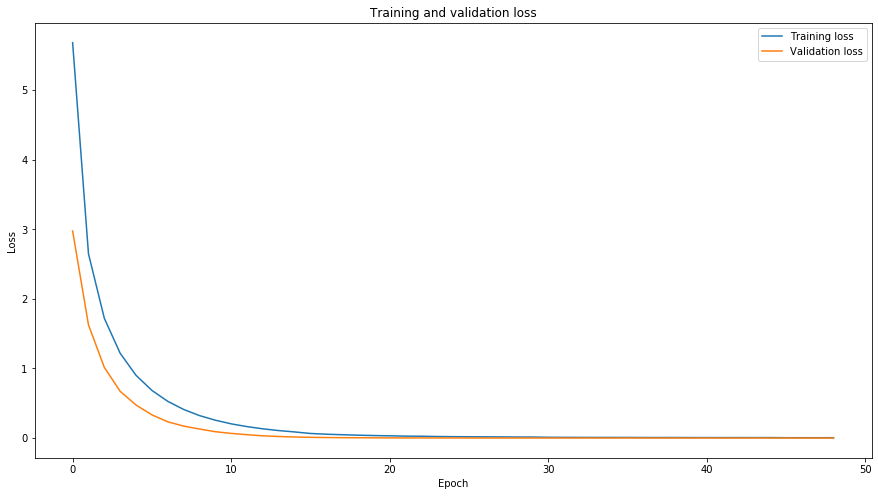

In [16]:
x = [epoch for epoch in range(len(train_loss_history))]
plt.figure(figsize=(15, 8))

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.plot(x, train_loss_history, label='Training loss')
plt.plot(x, val_loss_history, label='Validation loss')

plt.legend()

plt.show()

In [17]:
argmin_val = np.argmin(val_loss_history)
print('Least validation loss: {} in epoch {}'.format(val_loss_history[argmin_val], argmin_val))

Least validation loss: 6.716292312193389e-05 in epoch 48
